# Demonstration: Overlapping.hdf5
This notebook is aimed at giving you some support in accessing the data and using the reconstruction methods presented in the paper __Multilevel RTN removal tools for dynamic FBG strain measurements corrupted by peak splitting artefacts__.

Youll find a loop in which the provided data can be processed using either method. Furthermore you can plot all the results in one go (giving you ~45 figures); if that is to much you can choose to process only a few files or limit the amount of plots you want to see (e.g. only the reconstructed time series and not the hostrograms and so on).


# Imports and function definitions

## Imports
import python packages as well as the py_peak_splitting package. 

In [1]:
# basic imports: numpy, matplotlib and h5py
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl 

# Scipy imports:
from scipy import signal
import scipy.optimize as op
import scipy.signal as ss
import scipy.fftpack as fft
from scipy.signal import butter, filtfilt

# py_peak_splitting imports:
from py_peak_splitting import simulate_ps_signals as sim
from py_peak_splitting.th_filter import ThFilter as Th 
from py_peak_splitting.hampel_filter import Hampel as Ha

In [2]:
# set plot style: 
plt.style.use('seaborn-white')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Standalone functions used for processing and visualisation

Filter for post-processing, functions to defined the cost functions for offset calibration as well as subset selection:

In [4]:
def _butter(data, fs, sb, order=5, btype='low'):
    if isinstance(sb, (float, int)):
        sb = [sb]
    b, a = butter(order, [s / (0.5 * fs) for s in sb], btype=btype)
    return filtfilt(b, a, data)

def costfun_l2(x, arr, rec, t):
    """ Costfunction equals 2-norm of difference between raw and shifted signal. No local minima observed."""
    trend = x[0]*t + x[1]
    return np.linalg.norm((arr)-(rec+trend), ord=2)

def costfun_len(x, arr, rec, t):
    """ Costfunction maximizes number of samples of shifted reconstruction which are closer than 1 microstrain to the raw signal
    this one has local minima - constrain calibration subset, initialize with care (several times) or use robust algorithm.
    """
    trend = x[0]*t + x[1]
    pp = np.abs((arr)-(rec+trend))
    return len(arr)-np.sum(pp<1)

def bound_calibration_set(arr, rec, lb, ub):
    """ bound the calibration set to samples of the raw signal which fall between a lower and upper bound."""
    idx = ((arr>lb) & (arr<ub))
    t = np.arange(len(arr))
    return arr[idx], rec[idx], t[idx]
    

Some simple plot functions to compare raw data and reconstructions:

In [5]:
def plot(data, labels, xlim=[0, 2000], filt=True):

    if isinstance(data, np.ndarray):
        data = [data]
    t = np.arange(len(data[0]))
        
    _t = t[xlim[0]:xlim[1]] 
    _data = [ d[xlim[0]:xlim[1]] for d in data]
    
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    cols = mpl.colors.TABLEAU_COLORS
    for _d, _l, _c in zip(_data, labels, cols): 
        _d_sg = ss.savgol_filter(_d, 25, 1)
        _d_bt = _butter(_d, sb=[0.1, 5], fs=100, order=4, btype='band')
        ax.plot(_t, _d, label=_l + ' - data', c=_c)
        if filt: 
            ax.plot(_t, _d_sg, c=_c, ls='--', label=_l + ' - Savgol')
            ax.plot(_t, _d_bt, c=_c, ls='-.', label=_l + ' - Butter')
    
    ax.legend(bbox_to_anchor=(1.025, 1), loc='upper left',ncol=1, borderaxespad=0.)
    ax.set_xlim(xlim)    
    plt.show()
    
def plotHist(data, labels, order=1, bin_dens=10, yscale='log', th=None, filt=False):

    if isinstance(data, np.ndarray):
        data = [data]
    t = np.arange(len(data[0]))
            
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    cols = mpl.colors.TABLEAU_COLORS
    for _d, _l, _c in zip(data, labels, cols): 
        if filt: 
            _d = ss.savgol_filter(_d, 25, 1)
        _d = np.diff(_d, n=order)
        bins = int(np.ptp(_d)*bin_dens)
        ax.hist(_d, bins=bins, alpha=0.5, color=_c, label=_l + ' - diff. order:'+str(order))
   
        if th is not None and isinstance(th, (float, int)): 
            ax.axvline(-th, color=_c,  lw=2, ls='--')
            ax.axvline(th, color=_c,  lw=2, ls='--')

    ax.legend(bbox_to_anchor=(1.025, 1), loc='upper left',ncol=1, borderaxespad=0.)
    ax.set_yscale(yscale)
    plt.show()

# Data Import and Processing

In [6]:
# Open and read all arrays in hdf5 file
fo = h5py.File('../Overlapping.hdf5', 'r')
arr = list()
for i in  range(len(fo)) : 
    arr.append(fo[str(i)][:])
fo.close()

# make a pseudo time vector
t = np.arange(len(arr[0]))

## Hampel filter based reconstruction
basic functions call to perform a reconstruction using the hampel filter based implementation 

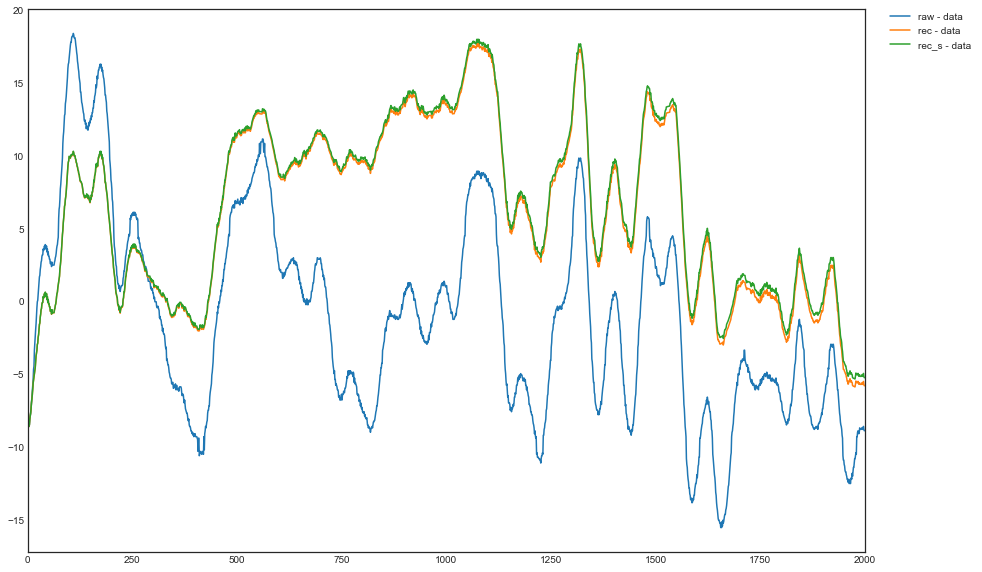

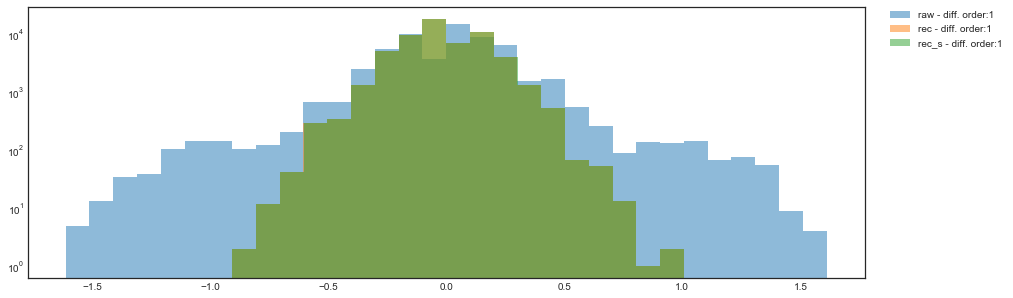

In [7]:
# Hampel filter based reconstruction: Separable
#
# ========================================================================
# reconstruction 
# -------------------------------------------------
a = arr[0]
h = Ha(a, th='sig', th_val= 1.96, re='plf', nperseg=50)
rec = h.reconstruction         
clu = h.clusters
lab = h.labels

# optimize trend
# -------------------------------------------------
# the calibration subset can be reduced to all points corresponding 
# to the samples of the raw signal which fall in <lb, ub>.
_arr, _rec, _t = bound_calibration_set(a, rec, lb=-8, ub=16)

# The default costfun is convex and can do withouth; but you can pass the reduced 
# subsets as argument of args (replace the tuple entries appropriately) when using 
# costfunctions which do have local minima. 
res = op.minimize(fun=costfun_l2,
                  args = (a, rec, t),
                  x0=[1, 0],
                  method='Nelder-Mead',
                  options={'maxiter':100})
rec_s = rec + res.x[0]*t + res.x[1]

# plot
plot([arr[0],rec, rec_s],['raw','rec','rec_s'], filt=0)
plotHist([arr[0],rec, rec_s],['raw','rec','rec_s'], order=1, bin_dens=10, th=None)

## Attributes and other options:

In [8]:
# basic resonstruction: 
h = Ha(a, th='sig', th_val= 3, re='plf', nperseg=50, avoid_implosion=True)

# attributes:
# -- List continaing lists of cluster indices
# -- [ [[indices inlier],[indices outlier]], ... ]
h.clusters

# -- List containing lists with counts
# -- [ [counts inlier, counts outlier], ... ]
h.counts

# -- List containing scores
# -- [score, ... ]
h.scores

# Re-creating the segment based thresholds:
dd = np.hstack([0, np.diff(arr[0])])
seg_arr = h._seg_array(dd, h.nperseg)
th_arr = h.th(seg=seg_arr, th=h.th_val)



## Threshold filter based reconstruction
basic functions call to perform a reconstruction using the threshold filter based implementation 

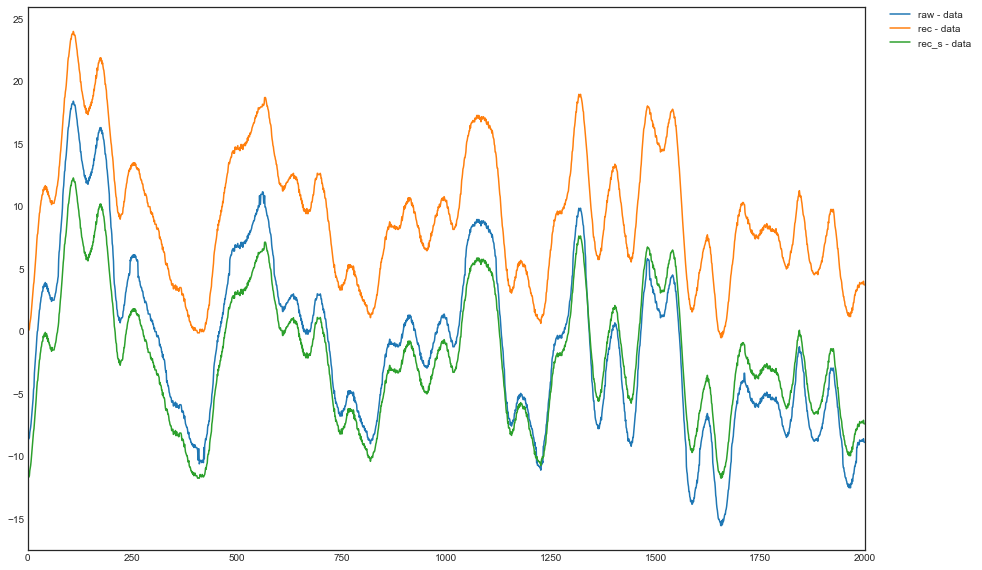

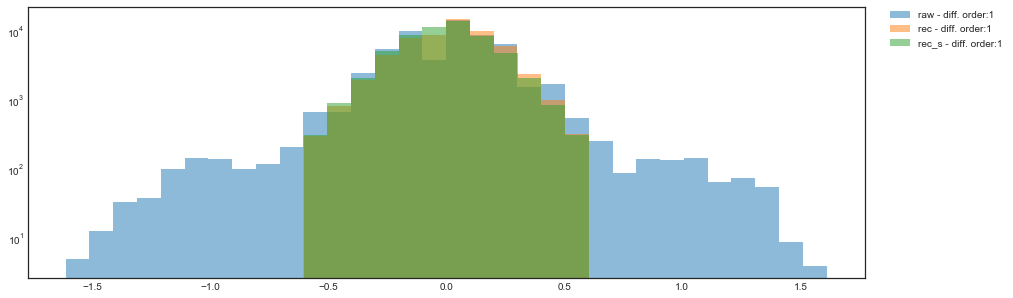

In [9]:
# Threshold filter based reconstruction: Separable
#
# ========================================================================

# reconstruction
# -------------------------------------------------
a = arr[0]
th = Th(arr=a)  
thv = th.estimate_th(aggressive=False, th=500, plot=False)
rec, clu, lab = th.recon_th(th=thv, method='polyfit', nbuffer=25)
rec = rec.flatten()

# optimize trend
# -------------------------------------------------
# the calibration subset can be reduced to all points corresponding 
# to the samples of the raw signal which fall in <lb, ub>.
_arr, _rec, _t = bound_calibration_set(a, rec, lb=-8, ub=16)

# The default costfun is convex and can do withouth; but you can pass the reduced 
# subsets as argument of args (replace the tuple entries appropriately) when using 
# costfunctions which do have local minima. 
res = op.minimize(fun=costfun_l2,
                  args = (a, rec, t),
                  x0=[1, 0],
                  method='Nelder-Mead',
                  options={'maxiter':100})
rec_s = rec + res.x[0]*t + res.x[1]


# plot
plot([a,rec, rec_s],['raw','rec','rec_s'], filt=0)
plotHist([a ,rec, rec_s],['raw','rec','rec_s'], order=1, bin_dens=10)

## Attributes and other options: 

In [10]:
th.labels
th.clusters 
th.counts

# range of raw and difference signals
th.sig_ptp(order=0)
th.sig_ptp(order=1)

# if you manually want to experiment with threshold settings, you can visualise histogrmas with th values
th.estimate_th(arr=None, th=500, bin_density=10, margin=1, centric=True, aggressive=False, plot=False, kde=False, yscale='log', lhb=0.2)

# estimate ratio of outliers and number of samples
th.estimate_oocs(arr=None, th=500, bin_density=10, margin=1, centric=True, aggressive=False)

# low level call to reconstruction 
rec, clu, lab = th.recon_th(arr=None, time=None, th=None, method='median', nbuffer=25, settings=None, )